# Gradient descent training of a feed-forward spiking neuron layer

## Requirements and housekeeping

In [2]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rockpool
from rockpool import TSEvent, TSContinuous
from rockpool.layers import RecLIFCurrentInJax, RecLIFJax, RecLIFJax_IO, FFLIFJax_IO

# - Typing
from typing import Callable, Dict, Tuple
import types

# Numpy
import numpy as np

# TQDM
from tqdm.autonotebook import tqdm

# Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]

## Signal generation from frozen noise task
We will use a single feed-forward layer of spiking neurons to convert a chosen pattern of random input spikes over time, into a pre-defined remporal signal with complex dynamics.

The network architecture is strictly feedforward, but the spiking neurons nevertheless contain temporal dynamics in their synaptic and membrane signals, with explicit time constants.

Some number of input channels `Nin` will contain independent Poisson spikes at some rate `spiking_prob/dt`. A single output channel should generate a chirp signal with increasing frequency, up to a maximum of `chirp_freq_factor`. You can play with these parameters below.

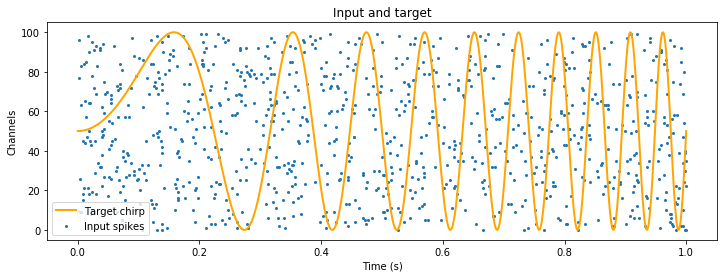

In [3]:
# - Define input and target
Nin = 100
dt = 1e-3
chirp_freq_factor = 10
dur_input = 1000e-3

# - Generate a time base
T = int(np.round(dur_input / dt))
timebase = np.linspace(0, T * dt, T)

# - Generate a chirp signal as a target
chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T
target_ts = TSContinuous(timebase, chirp, periodic = True, name = 'Target chirp')

# - Generate a Poisson frozen random spike train
spiking_prob = .01
sp_in_ts = np.random.rand(T, Nin) < spiking_prob
spikes = np.argwhere(sp_in_ts)
input_sp_ts = TSEvent(timebase[spikes[:, 0]], spikes[:, 1], name = 'Input spikes', periodic = True,
                      t_start = 0, t_stop = dur_input,
                     )

# - Plot the input and target signals
plt.figure()
input_sp_ts.plot(s = 4)
(target_ts * Nin/2 + Nin/2).plot(color="orange", lw=2)
plt.legend()
plt.title('Input and target');

## LIF neuron
The spiking neuron we will use is a leaky integrate-and-fire spiking neuron ("LIF" neuron). This neuron recevies input spike trains $S_{in}(t) = \sum_j\delta(t-t_j)$, which are integrated via weighted exponential synapses. Synaptic currents are then integrated into a neuron state ("membrane potential") $V_{mem}$.

The neuron obeys the dynamics
$$\tau_{mem}\cdot\dot{V}_{mem} + V_{mem} = {I}_{syn} + I_{bias} + \sigma\zeta(t)$$
$$\tau_{syn}\cdot\dot{I}_{syn} + I_{syn} = 0$$
$$I_{syn} += W_{in} \cdot S_{in}(t)$$

Where $\tau_{mem}$ and $\tau_{syn}$ are membrane and synaptic time constants; $I_{bias}$ is a constant bias current for each neuron; $\sigma\zeta(t)$ is a white noise process with std. dev. $\sigma$.

Output spikes are generated when $V_{mem}$ crosses the firing threshold $V_{th} = 1$. This process generates a spike train $S(t)$ as a series of delta functions, and causes a subtractive reset of $V_{mem}$:

$$V_{mem} > V_{th} \rightarrow S(t) = H(V_{mem}(t)), V_{mem} = V_{mem} - 1$$

The analog output signal is generated using a surrogate
$$U(t) = [1+\exp(10 * V_{mem}(t))]^{-1}$$

The output $o(t)$ is therefore given by
$$o(t) = W_{out} \cdot U(t)$$

## Build a network
The network architecture is a single feedforward layer, with weighted spiking inputs and outputs. The analog output signal is generated by a weighted surrogate signal $S^*(t)$, generated directly from the membrane potential $V_{mem}(t)$ and bypassing spike generation. This permits propagation of an error gradient through the layer, making gradient-descent training possible.

You can play with the network size `N` below, as well as the initial membrane and synapse time constants `tau_mem` and `tau_syn`, and the initial bias `bias`. All these parameters will be optimised during training.

In [4]:
# - Network size
N = 50
Nout = 1

# - Initial parameters
tau_mem = 10e-3
tau_syn = 100e-3
bias = 0.

def rand_params(N, Nin, Nout, tau_mem, tau_syn, bias):
    return {
        'w_in': np.random.rand(Nin, N) - .5,
        'w_out': 2 * np.random.rand(N, Nout) - 1,
        'tau_mem': tau_mem,
        'tau_syn': tau_syn,
        'bias': bias,
    }

In [5]:
# - Generate an initial random network
params0 = rand_params(N, Nin, Nout, tau_mem, tau_syn, bias)
lyrIO = FFLIFJax_IO(**params0, dt = dt, name = "Jax LIF")
lyrIO

FFLIFJax_IO object: "Jax LIF" [100 TSEvent in -> 50 internal -> 1 TSContinuous out]

## Simulate initial state of network
If we simulate the untrained network with our random input spikes, we don't expect anything sensible to come out. Let's do this, and take a look at how the network behaves.

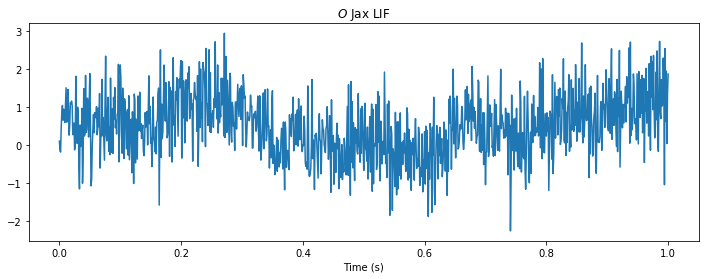

In [6]:
# - Randomise the network state
lyrIO.randomize_state()

# - Evolve with the frozen noise spiking input
tsOutput = lyrIO.evolve(input_sp_ts)

# - Plot the analog output
plt.figure()
tsOutput.plot();

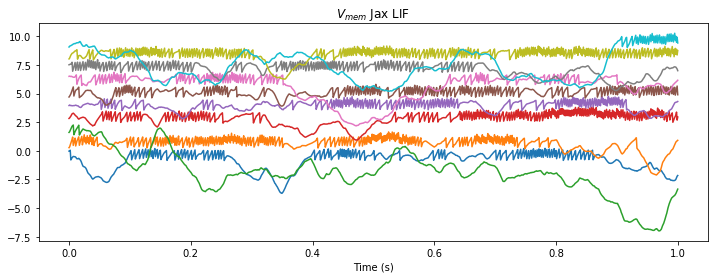

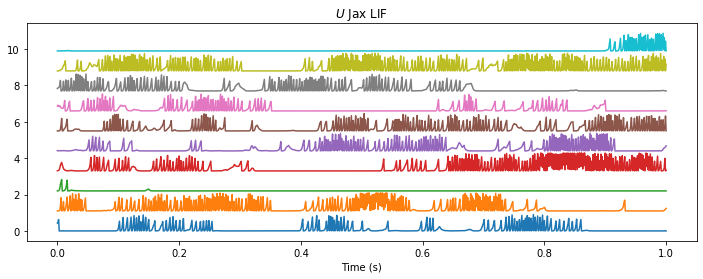

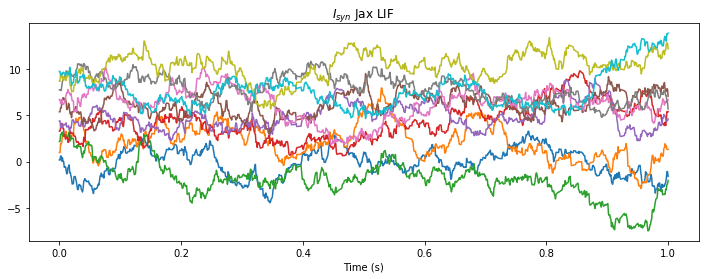

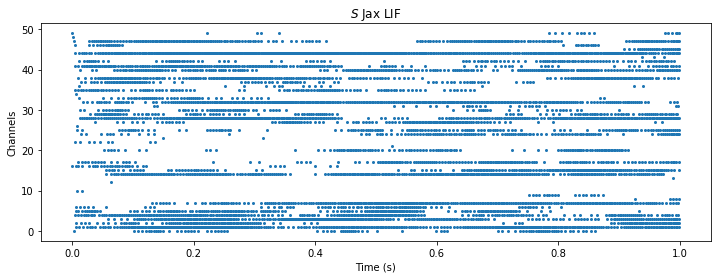

In [7]:
# - Plot the internal activity of selected neurons
plt.figure()
lyrIO.v_mem_last_evolution.plot(stagger = 1.1, skip = 5)

plt.figure()
lyrIO.surrogate_last_evolution.plot(stagger = 1.1, skip = 5)

plt.figure()
lyrIO.i_syn_last_evolution.plot(stagger = 1.1, skip = 5)

plt.figure()
lyrIO.spikes_last_evolution.plot(s=4);

## Using the training shim

In [8]:
# - Import the training shim
from rockpool.layers.training import add_shim_lif_jax_sgd

# - Add training capabilities to the layer
lyrIO = add_shim_lif_jax_sgd(lyrIO)

In [9]:
# - Define how many trials of SGD to perform
steps = 10000

# - Perform gradient descent
loss_ts = np.zeros((steps, 6))
t_loss = []
i = 0

for t in tqdm(range(steps), desc='Training'):
    lyrIO.randomize_state()
    l_fcn, g_fcn = lyrIO.train_output_target(input_sp_ts, target_ts, is_first = (t == 0))
    
    if t % 10 == 0:
        _, (_, dLoss, _) = l_fcn()
        loss_ts[i, :] = np.array(list(dLoss.values()))
        t_loss.append(t)
        i += 1
        
loss_ts = loss_ts[:i]

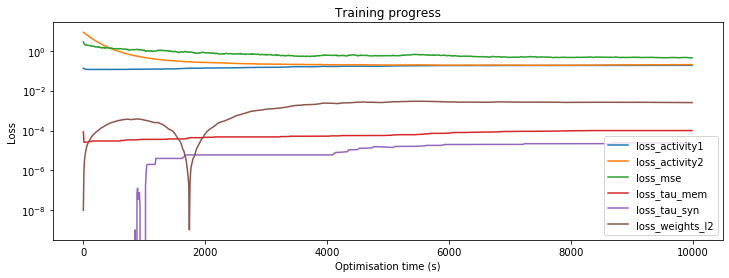

In [10]:
# - Plot the loss 
plt.figure()
plt.plot(t_loss, loss_ts[:i])
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Optimisation time (s)');
plt.title('Training progress')
plt.legend(dLoss.keys());

## Plot the ouput of the trained network

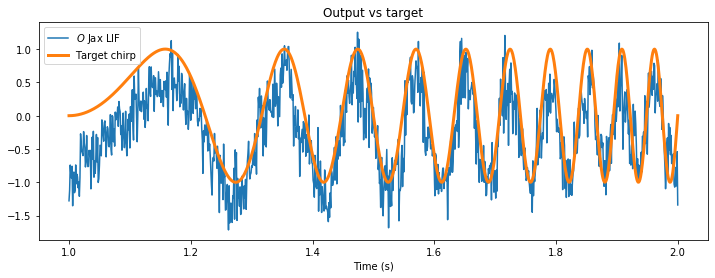

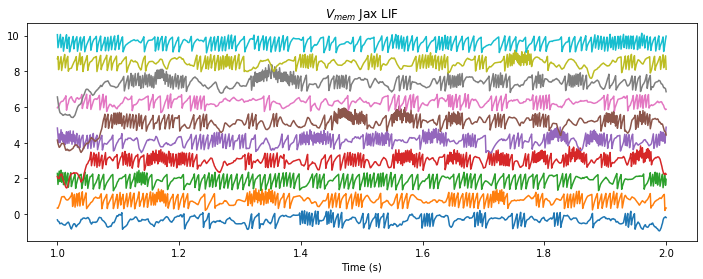

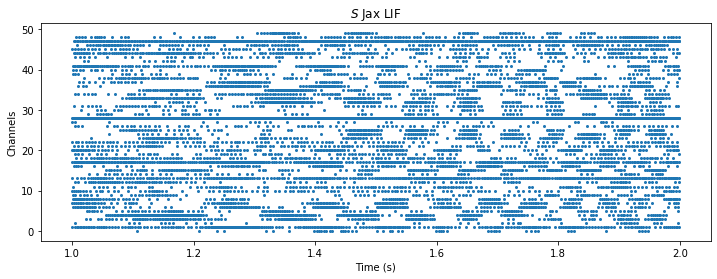

In [11]:
# - Simulate with trained parameters
output_ts = lyrIO.evolve(input_sp_ts)

# - Compare the output to the target
output_ts.plot()
target_ts.plot(output_ts.times, lw=3)
plt.legend();
plt.title('Output vs target')

# - Plot the internal state of selected neurons
plt.figure()
lyrIO.v_mem_last_evolution.plot(stagger = 1.1, skip = 5);

plt.figure()
lyrIO.spikes_last_evolution.plot(s=4);

## Plot the network parameters
Let's see how much the network parameters changed. Since the initial parameter set was random, we'll plot the difference between the trained and initial parameters $\theta^* - \theta$.

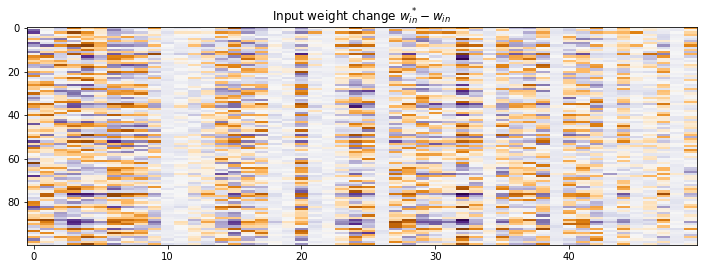

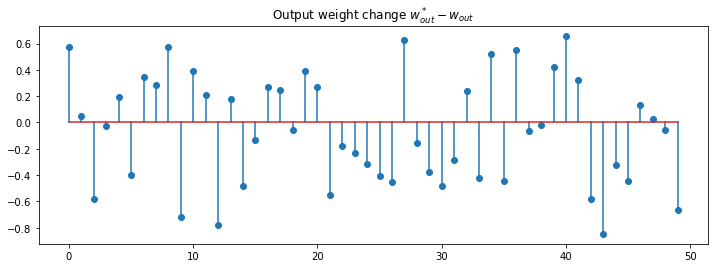

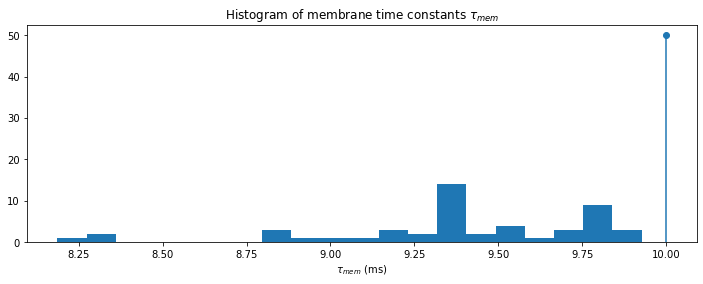

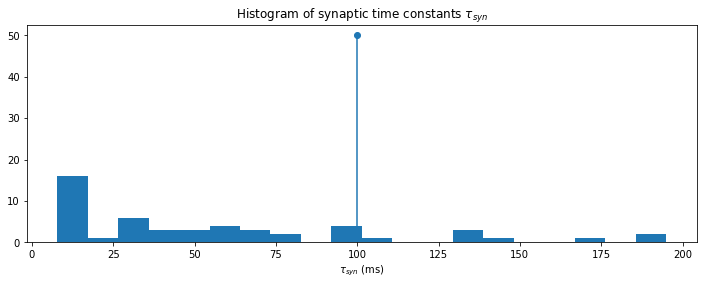

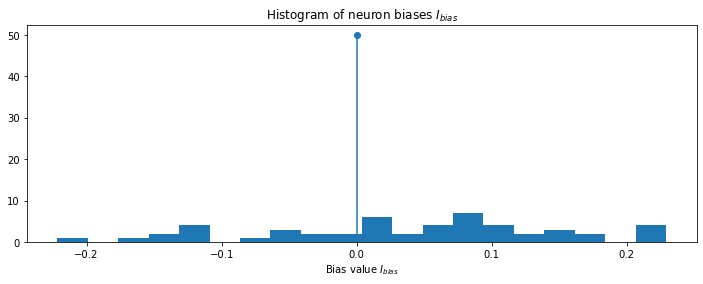

In [12]:
# - Plot the change in input weights
plt.figure()
plt.imshow(lyrIO.w_in - params0['w_in'], aspect = "auto");
plt.title('Input weight change $w^*_{in}-w_{in}$')
plt.set_cmap('PuOr')

# - Plot the change in output weights
plt.figure()
plt.stem(lyrIO.w_out - params0['w_out'])
plt.title('Output weight change $w^*_{out}-w_{out}$')

# - Plot the distribution of final time constants
plt.figure()
plt.hist(lyrIO.tau_mem * 1e3, 20)
plt.stem([tau_mem * 1e3], [50])
plt.xlabel('$\\tau_{mem}$ (ms)')
plt.title('Histogram of membrane time constants $\\tau_{mem}$')

plt.figure()
plt.hist(lyrIO.tau_syn * 1e3, 20)
plt.stem([tau_syn * 1e3], [50])
plt.xlabel('$\\tau_{syn}$ (ms)')
plt.title('Histogram of synaptic time constants $\\tau_{syn}$');

# - Plot the distribution of final biases
plt.figure()
plt.hist(lyrIO.bias, 20)
plt.stem([bias], [50])
plt.xlabel('Bias value $I_{bias}$')
plt.title('Histogram of neuron biases $I_{bias}$');

The power of automatic differentiation is that almost for free, we get to optimise not just the weights, but all time constants and biases simultaneously. And we didn't have to compute the gradients by hand!

As a sanity check, let's see how the trained network responds if we give it a different random noise input.

In [13]:
spiking_prob = .01
sp_rand_ts = np.random.rand(T, Nin) < spiking_prob
spikes = np.argwhere(sp_rand_ts)
random_sp_ts = TSEvent(timebase[spikes[:, 0]], spikes[:, 1], name = 'Input spikes', periodic = True,
                      t_start = 0, t_stop = dur_input,
                     )

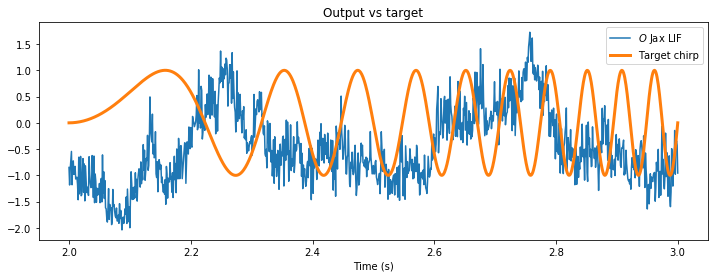

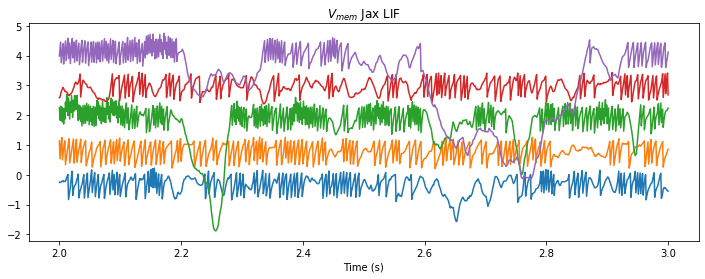

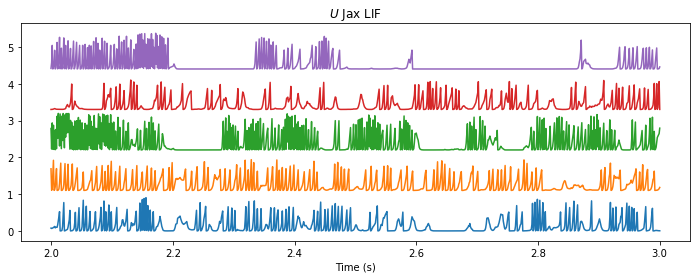

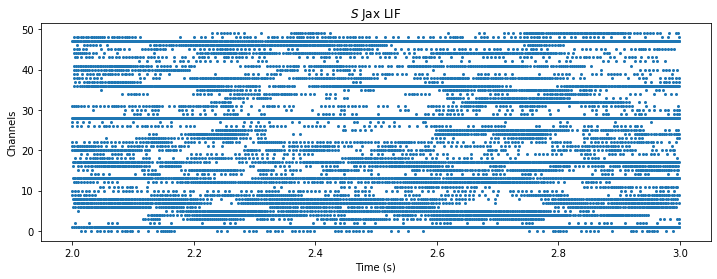

In [14]:
# - Simulate with trained parameters
output_ts = lyrIO.evolve(random_sp_ts)

output_ts.plot()
target_ts.plot(output_ts.times, lw=3)
plt.legend();
plt.title('Output vs target')

plt.figure()
lyrIO.v_mem_last_evolution.plot(stagger = 1.1, skip = 10);

plt.figure()
lyrIO.surrogate_last_evolution.plot(stagger = 1.1, skip = 10);

plt.figure()
lyrIO.spikes_last_evolution.plot(s=4);

As expected, the network doesn't do anything sensible with data it has never seen.

## Summary
This approach can be used identically to train recurrent spiking networks, as well as multi-layer (i.e. deep) networks, if you can define sensible targets for each layer.